# DTM analysis for visualization of changes in topic proportions and composition

## Install and import packages

In [28]:
%pip install gensim matplotlib pandas numpy nltk wordcloud

# 必要なライブラリをインポート
import pandas as pd
import numpy as np
import gensim
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
import matplotlib.pyplot as plt
from datetime import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from wordcloud import WordCloud

# ストップワードの設定
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data and preprocess

In [29]:
# CSVデータの読み込み
data = pd.read_csv("./submissions_Palestine_Israel_IsraelPalestine_20241026_173259.csv")

# created_utc列をdatetime型に変換
data['created_utc'] = pd.to_datetime(data['created_utc'])

# テキストデータの前処理関数
def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # 小文字化とトークン化
    tokens = [word for word in tokens if word.isalpha()]  # 非アルファベット文字を除去
    tokens = [word for word in tokens if word not in stop_words]  # ストップワードを除去
    return tokens

# 前処理済みのテキスト列を追加
data['text'] = data['text'].astype(str)
data['processed_text'] = data['text'].apply(preprocess_text)

## Determine Optimal Number of Topics

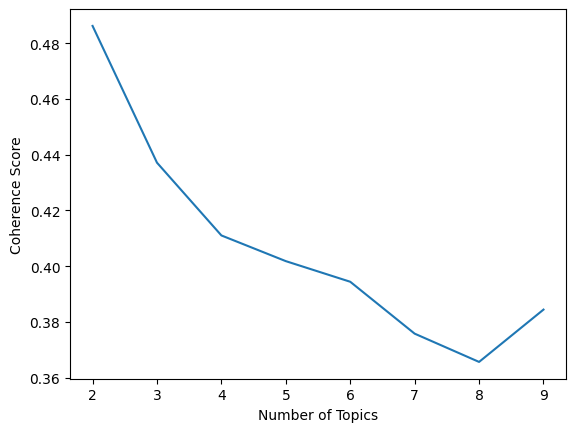

In [30]:
# データを週ごとに分割
data['week'] = data['created_utc'].dt.to_period('W')
weekly_data = {week: group['processed_text'].tolist() for week, group in data.groupby('week')}

# コヒーレンススコアに基づくトピック数の決定
def compute_coherence(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return coherence_values

# 最適なトピック数の検索（例として最大10まで）
limit = 10
texts = [item for sublist in weekly_data.values() for item in sublist]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

coherence_values = compute_coherence(dictionary, corpus, texts, limit)

# コヒーレンススコアをプロット
plt.plot(range(2, limit), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

# 最適なトピック数を選択
optimal_topic_count = coherence_values.index(max(coherence_values)) + 2

## Build Dynamic Topic Model

In [31]:
# 週ごとのLDAモデル構築とトピック分布取得
weekly_lda_models = {}
weekly_topic_distributions = {}

for week, texts in weekly_data.items():
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=optimal_topic_count, random_state=42)
    weekly_lda_models[week] = lda_model
    weekly_topic_distributions[week] = [dict(lda_model.get_document_topics(corpus[i])) for i in range(len(corpus))]

# トピック割合の変化をプロット
topic_trends = pd.DataFrame()

for week, topic_dists in weekly_topic_distributions.items():
    weekly_topic_means = pd.DataFrame(topic_dists).mean()
    topic_trends = pd.concat([topic_trends, pd.DataFrame(weekly_topic_means, columns=[week])], axis=1)

## Visualization

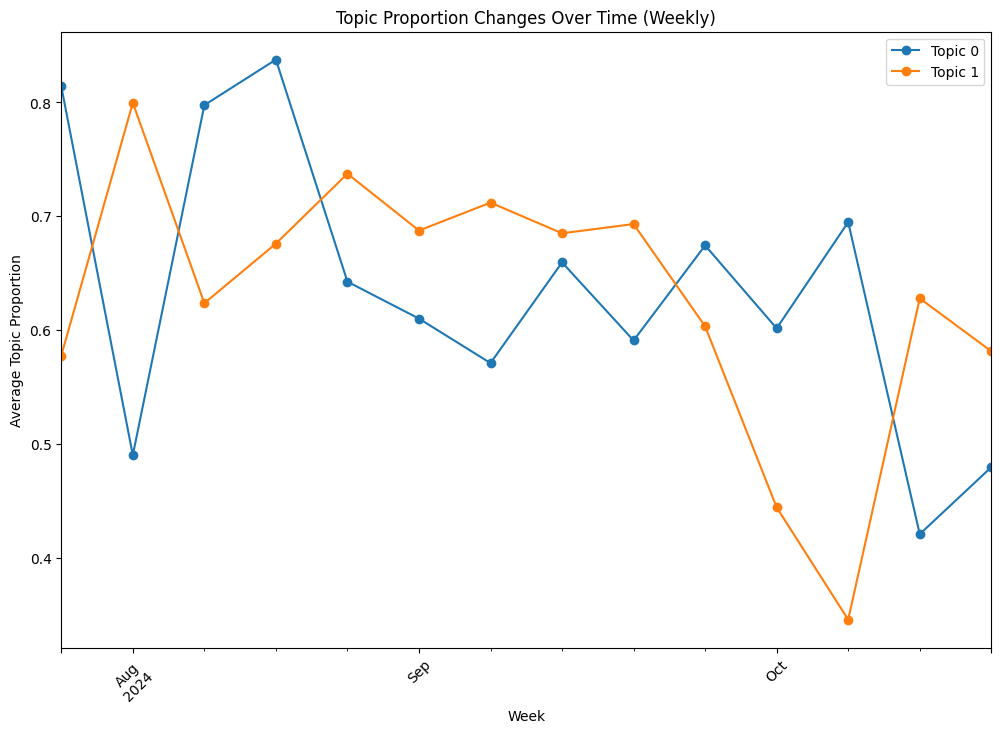

Week: 2024-07-22/2024-07-28
  Topic 1: people (0.016), druze (0.009), israel (0.008), israelis (0.007), jewish (0.007), israeli (0.007), idf (0.006), https (0.006), hezbollah (0.006), post (0.006)
  Topic 2: israel (0.015), people (0.013), druze (0.012), hezbollah (0.010), idf (0.009), israeli (0.009), https (0.008), israelis (0.007), jews (0.007), jewish (0.006)


Week: 2024-07-29/2024-08-04
  Topic 1: israel (0.014), hamas (0.009), people (0.006), like (0.006), gaza (0.006), https (0.005), would (0.005), israeli (0.004), one (0.004), palestinians (0.004)
  Topic 2: israel (0.011), people (0.008), hamas (0.005), one (0.005), gaza (0.005), would (0.004), palestinian (0.004), war (0.004), https (0.003), palestinians (0.003)


Week: 2024-08-05/2024-08-11
  Topic 1: https (0.011), israel (0.010), would (0.006), israeli (0.005), palestinians (0.005), palestinian (0.005), war (0.005), gaza (0.004), jewish (0.004), hamas (0.004)
  Topic 2: israel (0.011), years (0.007), https (0.006), people

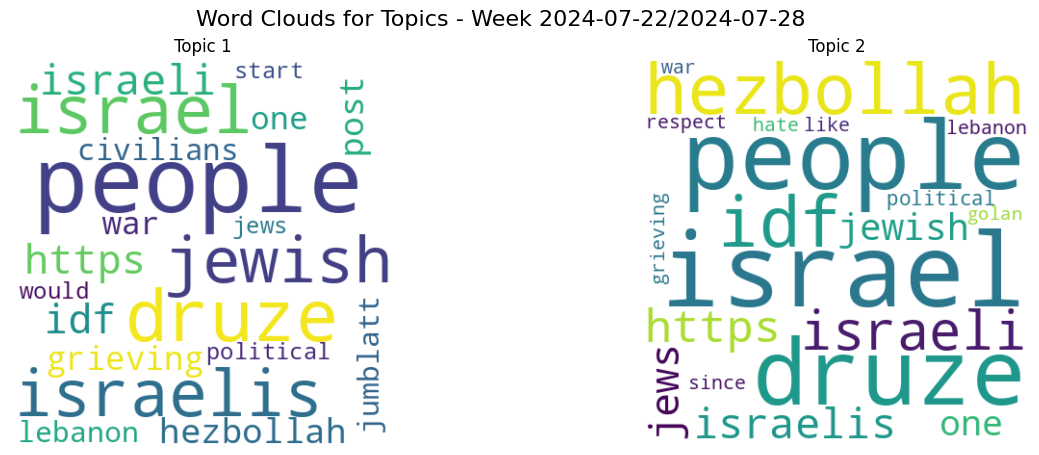



Week: 2024-07-29/2024-08-04


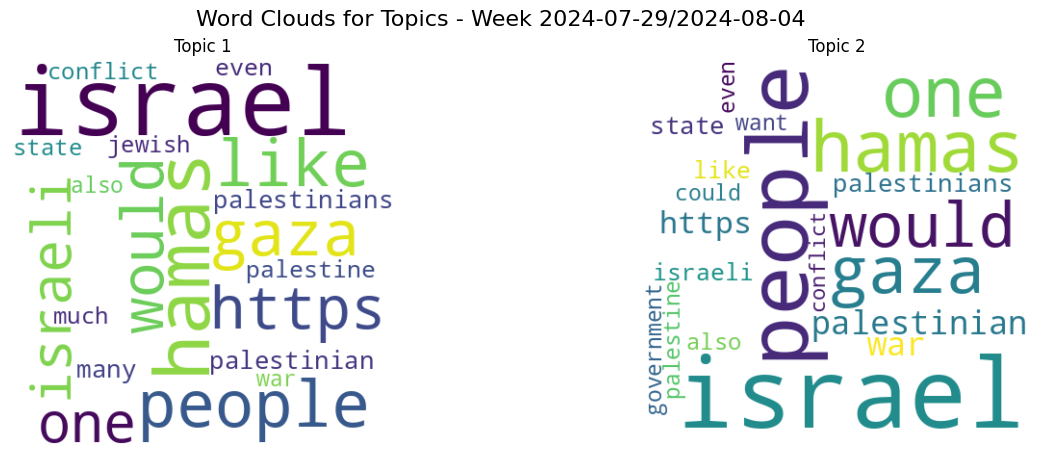



Week: 2024-08-05/2024-08-11


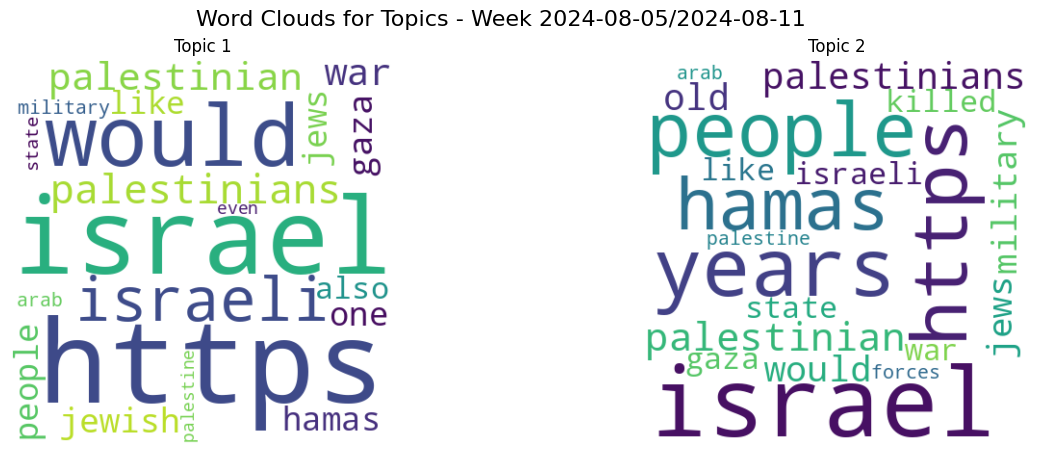



Week: 2024-08-12/2024-08-18


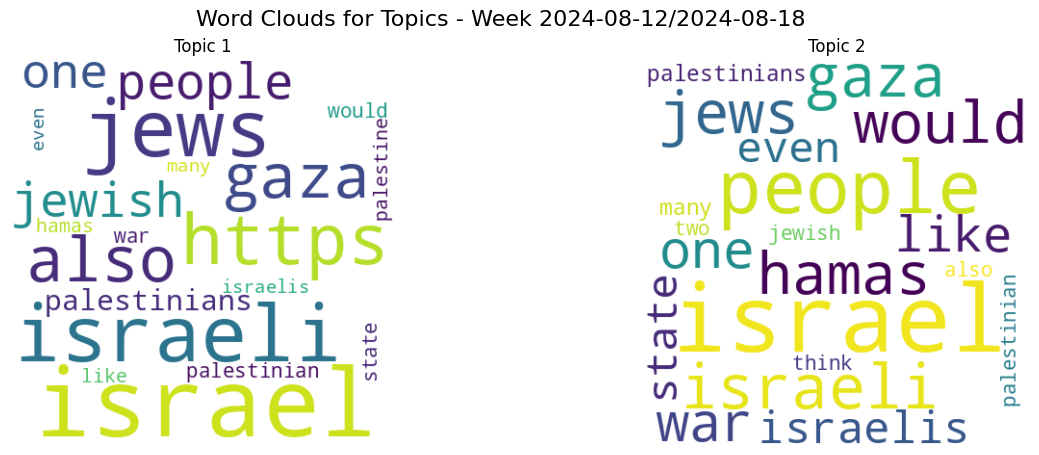



Week: 2024-08-19/2024-08-25


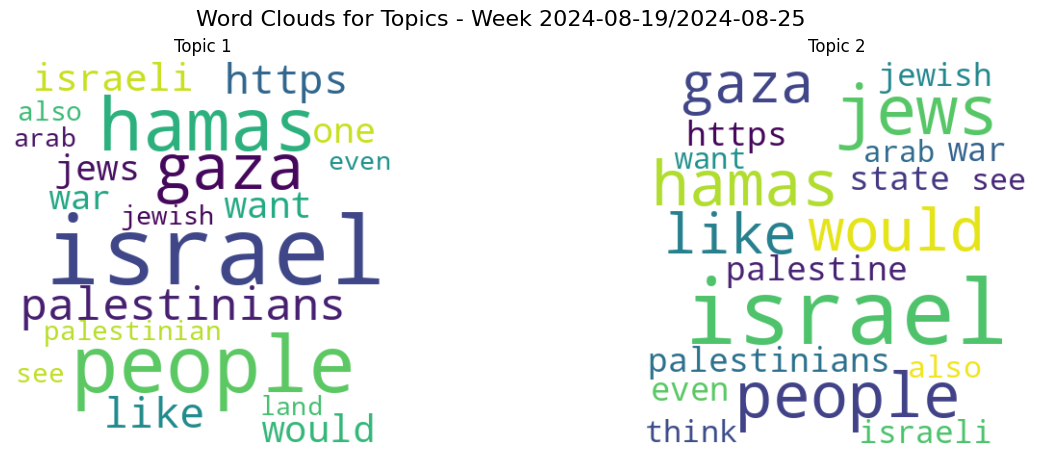



Week: 2024-08-26/2024-09-01


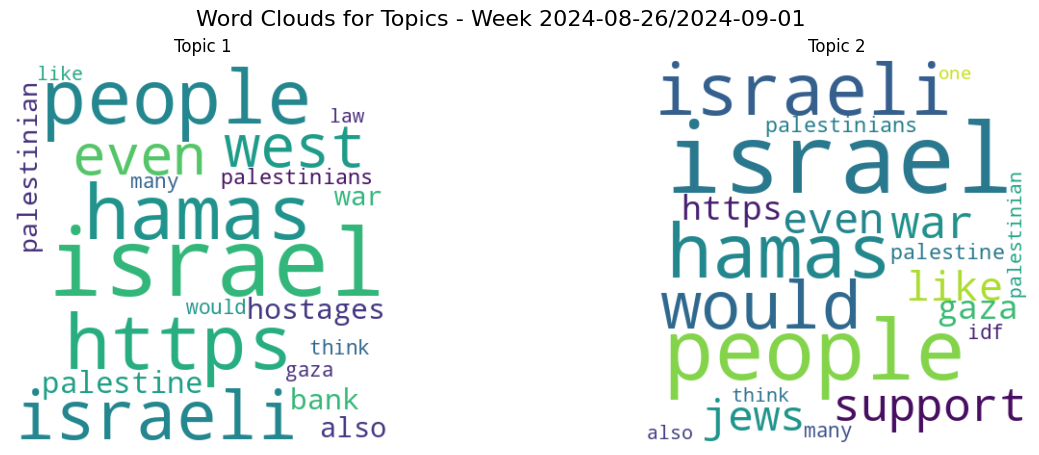



Week: 2024-09-02/2024-09-08


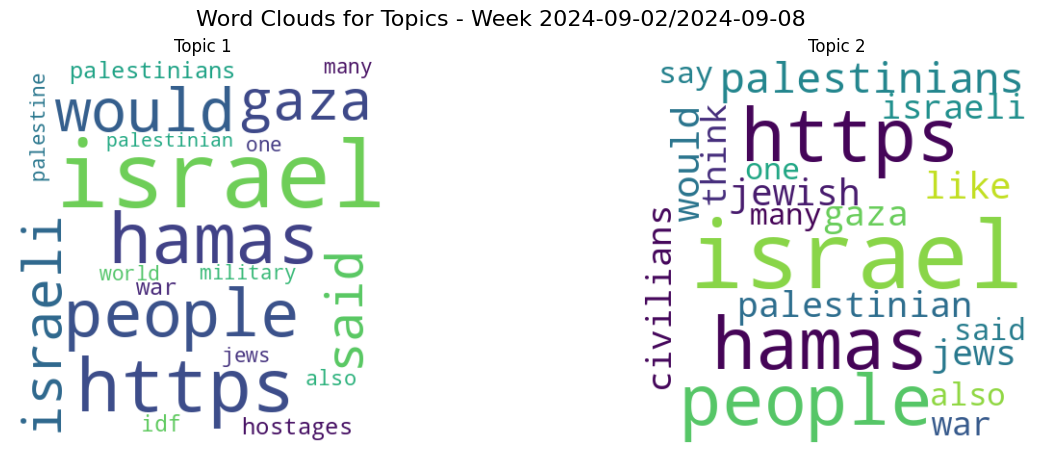



Week: 2024-09-09/2024-09-15


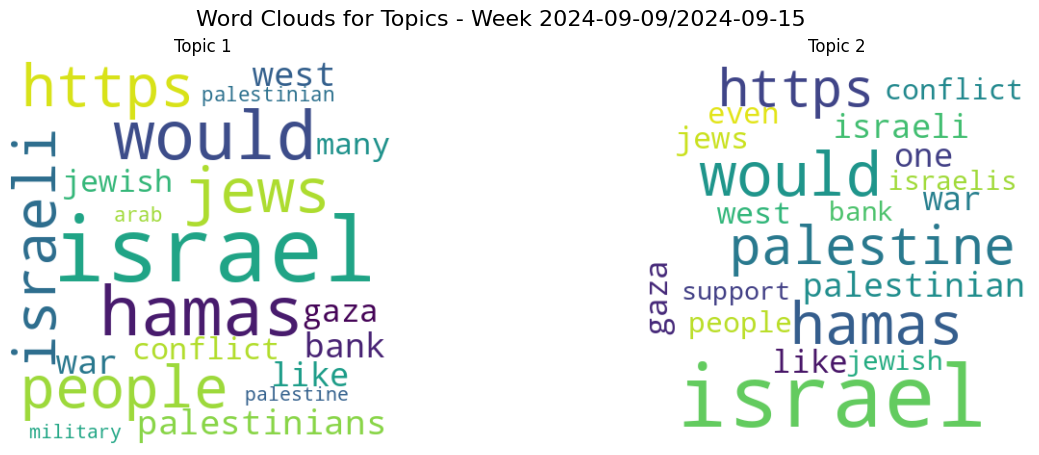



Week: 2024-09-16/2024-09-22


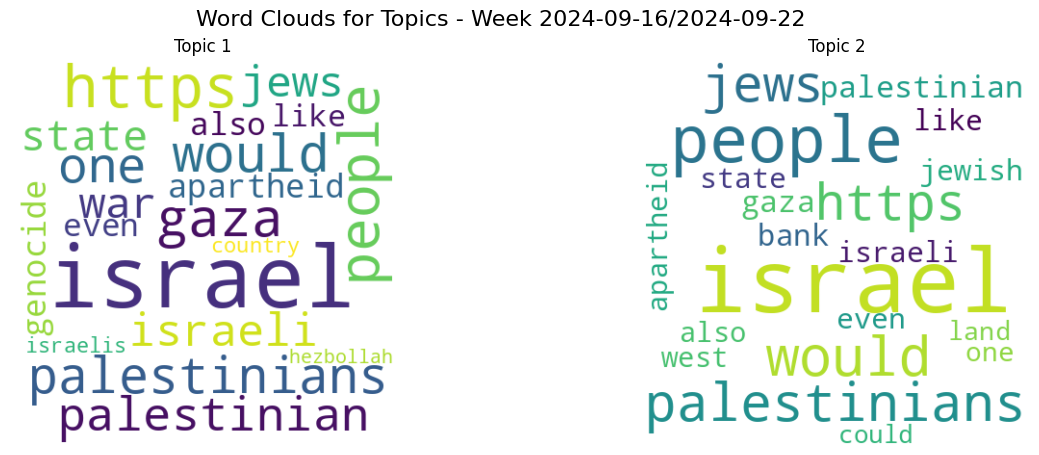



Week: 2024-09-23/2024-09-29


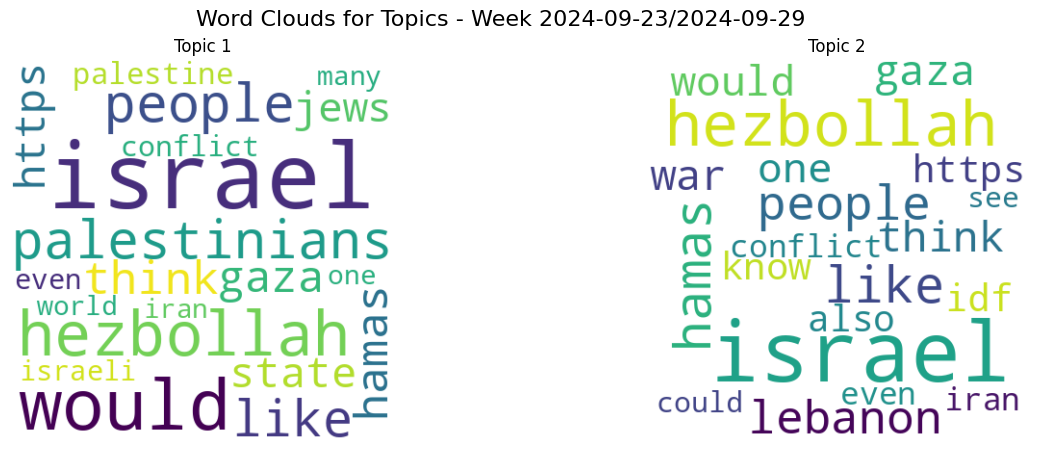



Week: 2024-09-30/2024-10-06


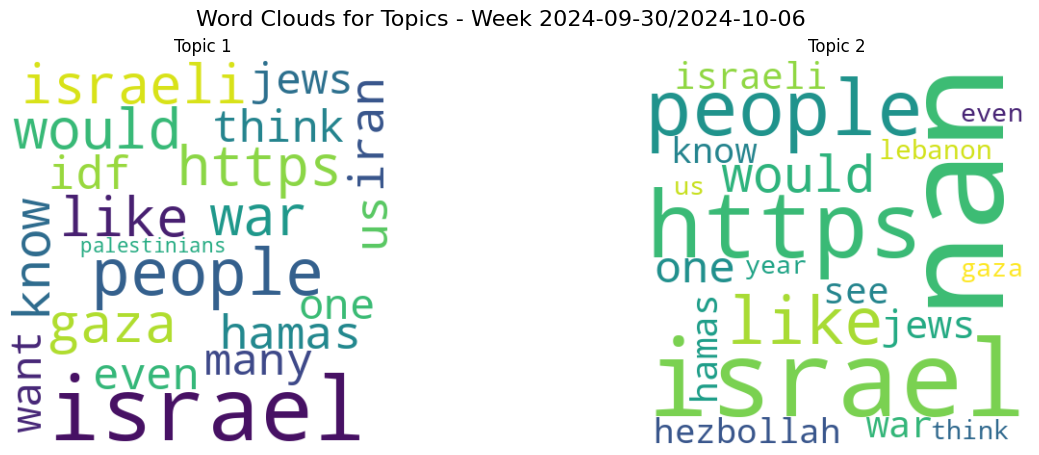



Week: 2024-10-07/2024-10-13


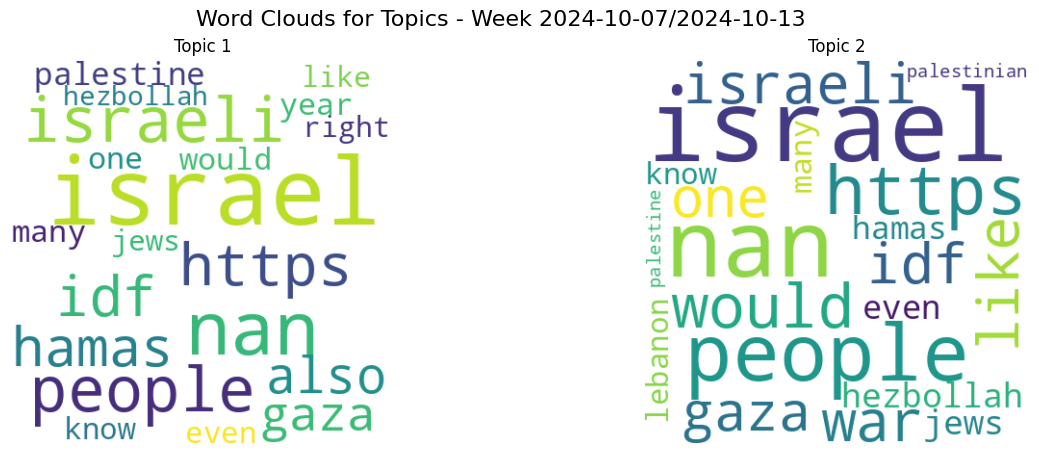



Week: 2024-10-14/2024-10-20


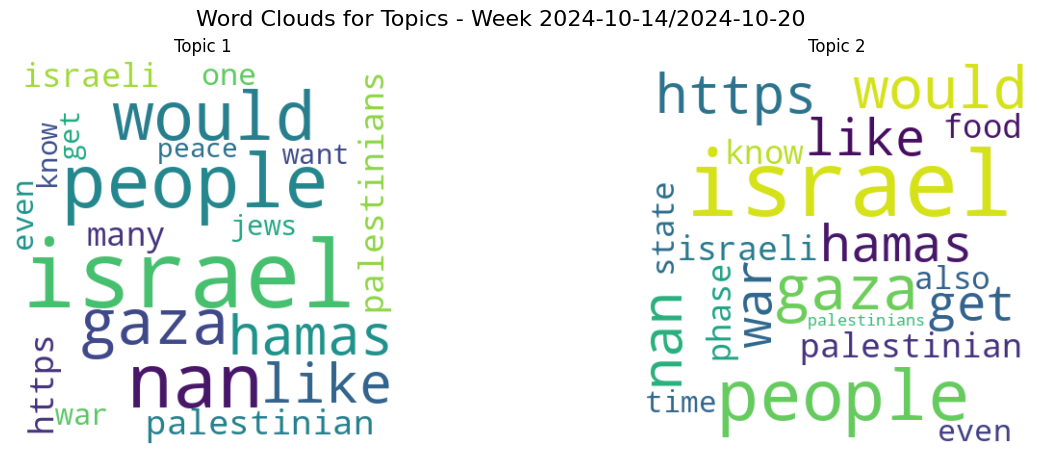



Week: 2024-10-21/2024-10-27


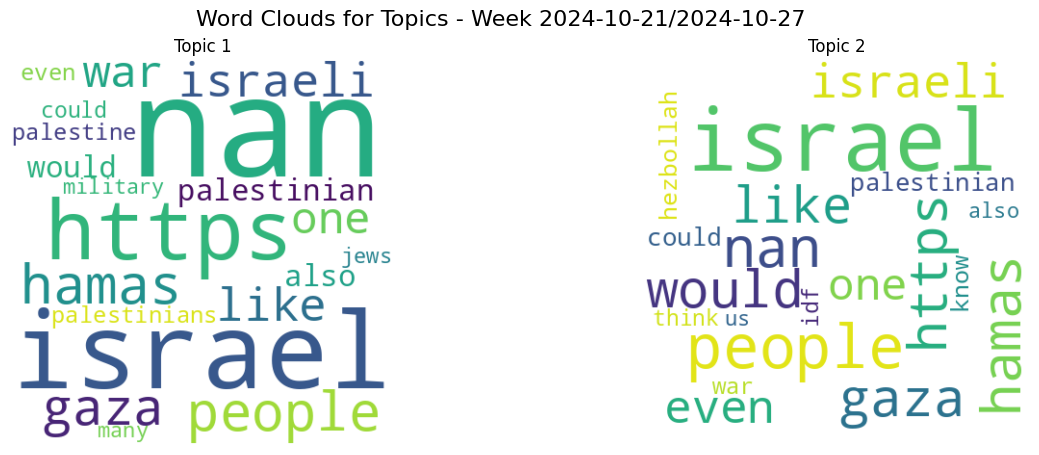

In [32]:
# トピック割合の時系列変化をプロット
topic_trends = topic_trends.T  # 転置して週ごとに列を並べる
topic_trends.plot(kind='line', figsize=(12, 8), marker='o')
plt.xlabel("Week")
plt.ylabel("Average Topic Proportion")
plt.title("Topic Proportion Changes Over Time (Weekly)")
plt.legend([f"Topic {i}" for i in range(optimal_topic_count)])
plt.xticks(rotation=45)
plt.show()

# 各週のトピック構成要素を表示
for week, lda_model in weekly_lda_models.items():
    print(f"Week: {week}")
    for topic_id in range(optimal_topic_count):
        # トピックの構成要素（単語とその寄与度）を取得
        topic_terms = lda_model.show_topic(topic_id, topn=10)  # トップ10の単語を表示
        terms_str = ", ".join([f"{word} ({weight:.3f})" for word, weight in topic_terms])
        print(f"  Topic {topic_id + 1}: {terms_str}")
    print("\n")

# 各週ごとのトピックのワードクラウドを生成
for week, lda_model in weekly_lda_models.items():
    print(f"Week: {week}")
    fig, axes = plt.subplots(1, optimal_topic_count, figsize=(15, 5))
    fig.suptitle(f"Word Clouds for Topics - Week {week}", fontsize=16)

    for topic_id in range(optimal_topic_count):
        # トピックの単語と重みを辞書形式に変換
        topic_terms = dict(lda_model.show_topic(topic_id, topn=20))  # 上位20単語
        wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(topic_terms)

        # 各トピックのワードクラウドをプロット
        axes[topic_id].imshow(wordcloud, interpolation='bilinear')
        axes[topic_id].axis('off')
        axes[topic_id].set_title(f"Topic {topic_id + 1}")

    plt.show()
    print("\n")